Import Modules

In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/AIML'
IMAGE_DIR = BASE_DIR + '/Images'
WORKING_DIR = BASE_DIR + '/features.pkl'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extract Image Features

In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
features = {}

# correct directory
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # full image path
    img_path = os.path.join(directory, img_name)

    # load the image
    image = load_img(img_path, target_size=(224, 224))

    # convert image pixels to numpy array
    image = img_to_array(image)

    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # preprocess image for VGG
    image = preprocess_input(image)

    # extract features
    feature = model.predict(image, verbose=0)

    # get image ID
    image_id = img_name.split('.')[0]

    # store feature
    features[image_id] = feature


100%|██████████| 8091/8091 [17:05<00:00,  7.89it/s]


In [ ]:
# store features in pickle (FINAL CORRECT VERSION)
import pickle

with open(WORKING_DIR, 'wb') as f:
    pickle.dump(features, f)

print("features.pkl saved successfully at:", WORKING_DIR)


features.pkl saved successfully at: /content/drive/MyDrive/AIML/features.pkl


In [ ]:
# load features from pickle (Cell 39 - corrected)
import pickle

with open(WORKING_DIR, 'rb') as f:
    features = pickle.load(f)

print("Features loaded successfully")
print("Number of images:", len(features))


Features loaded successfully
Number of images: 8091


Load the Captions Data

In [ ]:
# Load the captions data (CORRECTED)
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    captions_doc = f.read()

print("Captions file loaded successfully")
print("Total characters in captions:", len(captions_doc))


Captions file loaded successfully
Total characters in captions: 3319294


In [ ]:
captions_doc

'image,caption\n1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n10026741

In [ ]:
from tqdm import tqdm

mapping = {}

for line in tqdm(captions_doc.strip().split('\n')):
    line = line.strip()
    if len(line) == 0:
        continue

    # split only on the first space
    tokens = line.split(' ', 1)
    if len(tokens) < 2:
        continue

    image_id, caption = tokens

    # image_id: "667626_18933d713e.jpg#0"
    image_id = image_id.split('#')[0]    # remove #index
    image_id = image_id.split('.')[0]    # remove .jpg

    caption = caption.strip()

    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

print("Total images with captions:", len(mapping))

# SAFE example print (no IndexError)
if len(mapping) > 0:
    some_key = next(iter(mapping))
    print("Example ID:", some_key)
    print("Original captions:")
    for c in mapping[some_key]:
        print("  ", c)
else:
    print("⚠️ mapping is empty — captions format mismatch")


100%|██████████| 40456/40456 [00:00<00:00, 617174.65it/s]

Total images with captions: 8091
Example ID: 1000268201_693b08cb0e
Original captions:
   child in a pink dress is climbing up a set of stairs in an entry way .
   girl going into a wooden building .
   little girl climbing into a wooden playhouse .
   little girl climbing the stairs to her playhouse .
   little girl in a pink dress going into a wooden cabin .


In [ ]:
len(mapping)

8091

In [ ]:
import re

def clean(mapping):

    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]

            # convert to lowercase
            caption = caption.lower()

            # remove digits, punctuation, special chars (keep only letters + spaces)
            caption = re.sub(r'[^a-z\s]', ' ', caption)

            # collapse multiple spaces into one
            caption = re.sub(r'\s+', ' ', caption).strip()

            # keep words with len > 1, but keep 'a' and 'i'
            words = [word for word in caption.split() if (len(word) > 1 or word in ['a', 'i'])]

            # rebuild caption with start and end tags
            caption = 'startseq ' + " ".join(words) + ' endseq'

            captions[i] = caption


In [ ]:
mapping['12830823_87d2654e31']


['startseq sit and watch the fish moving in the pond endseq',
 'startseq stare at the orange fish endseq',
 'startseq people are standing near a fish pond endseq',
 'startseq children watching fish in a pool endseq',
 'startseq are several people and children looking into water with a blue tiled floor and goldfish endseq']

In [ ]:
clean(mapping)

In [ ]:
mapping['12830823_87d2654e31']

['startseq sit and watch the fish moving in the pond endseq',
 'startseq stare at the orange fish endseq',
 'startseq people are standing near a fish pond endseq',
 'startseq children watching fish in a pool endseq',
 'startseq are several people and children looking into water with a blue tiled floor and goldfish endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40453

In [ ]:
all_captions[:10]

['startseq child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq girl going into a wooden building endseq',
 'startseq little girl climbing into a wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in a pink dress going into a wooden cabin endseq',
 'startseq black dog and a spotted dog are fighting endseq',
 'startseq black dog and a tri colored dog playing with each other on the road endseq',
 'startseq black dog and a white dog with brown spots are staring at each other in the street endseq',
 'startseq dogs of different breeds looking at each other on the road endseq',
 'startseq dogs on pavement moving toward each other endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8348

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

37

Train Test Split

In [ ]:
image_ids_with_features = set(features.keys())
filtered_mapping = {img_id: captions for img_id, captions in mapping.items() if img_id in image_ids_with_features}
mapping = filtered_mapping # Update the mapping to use the filtered version
print(f"Number of images with features and captions: {len(mapping)}")

image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

Number of images with features and captions: 8091


In [ ]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

Model Creation

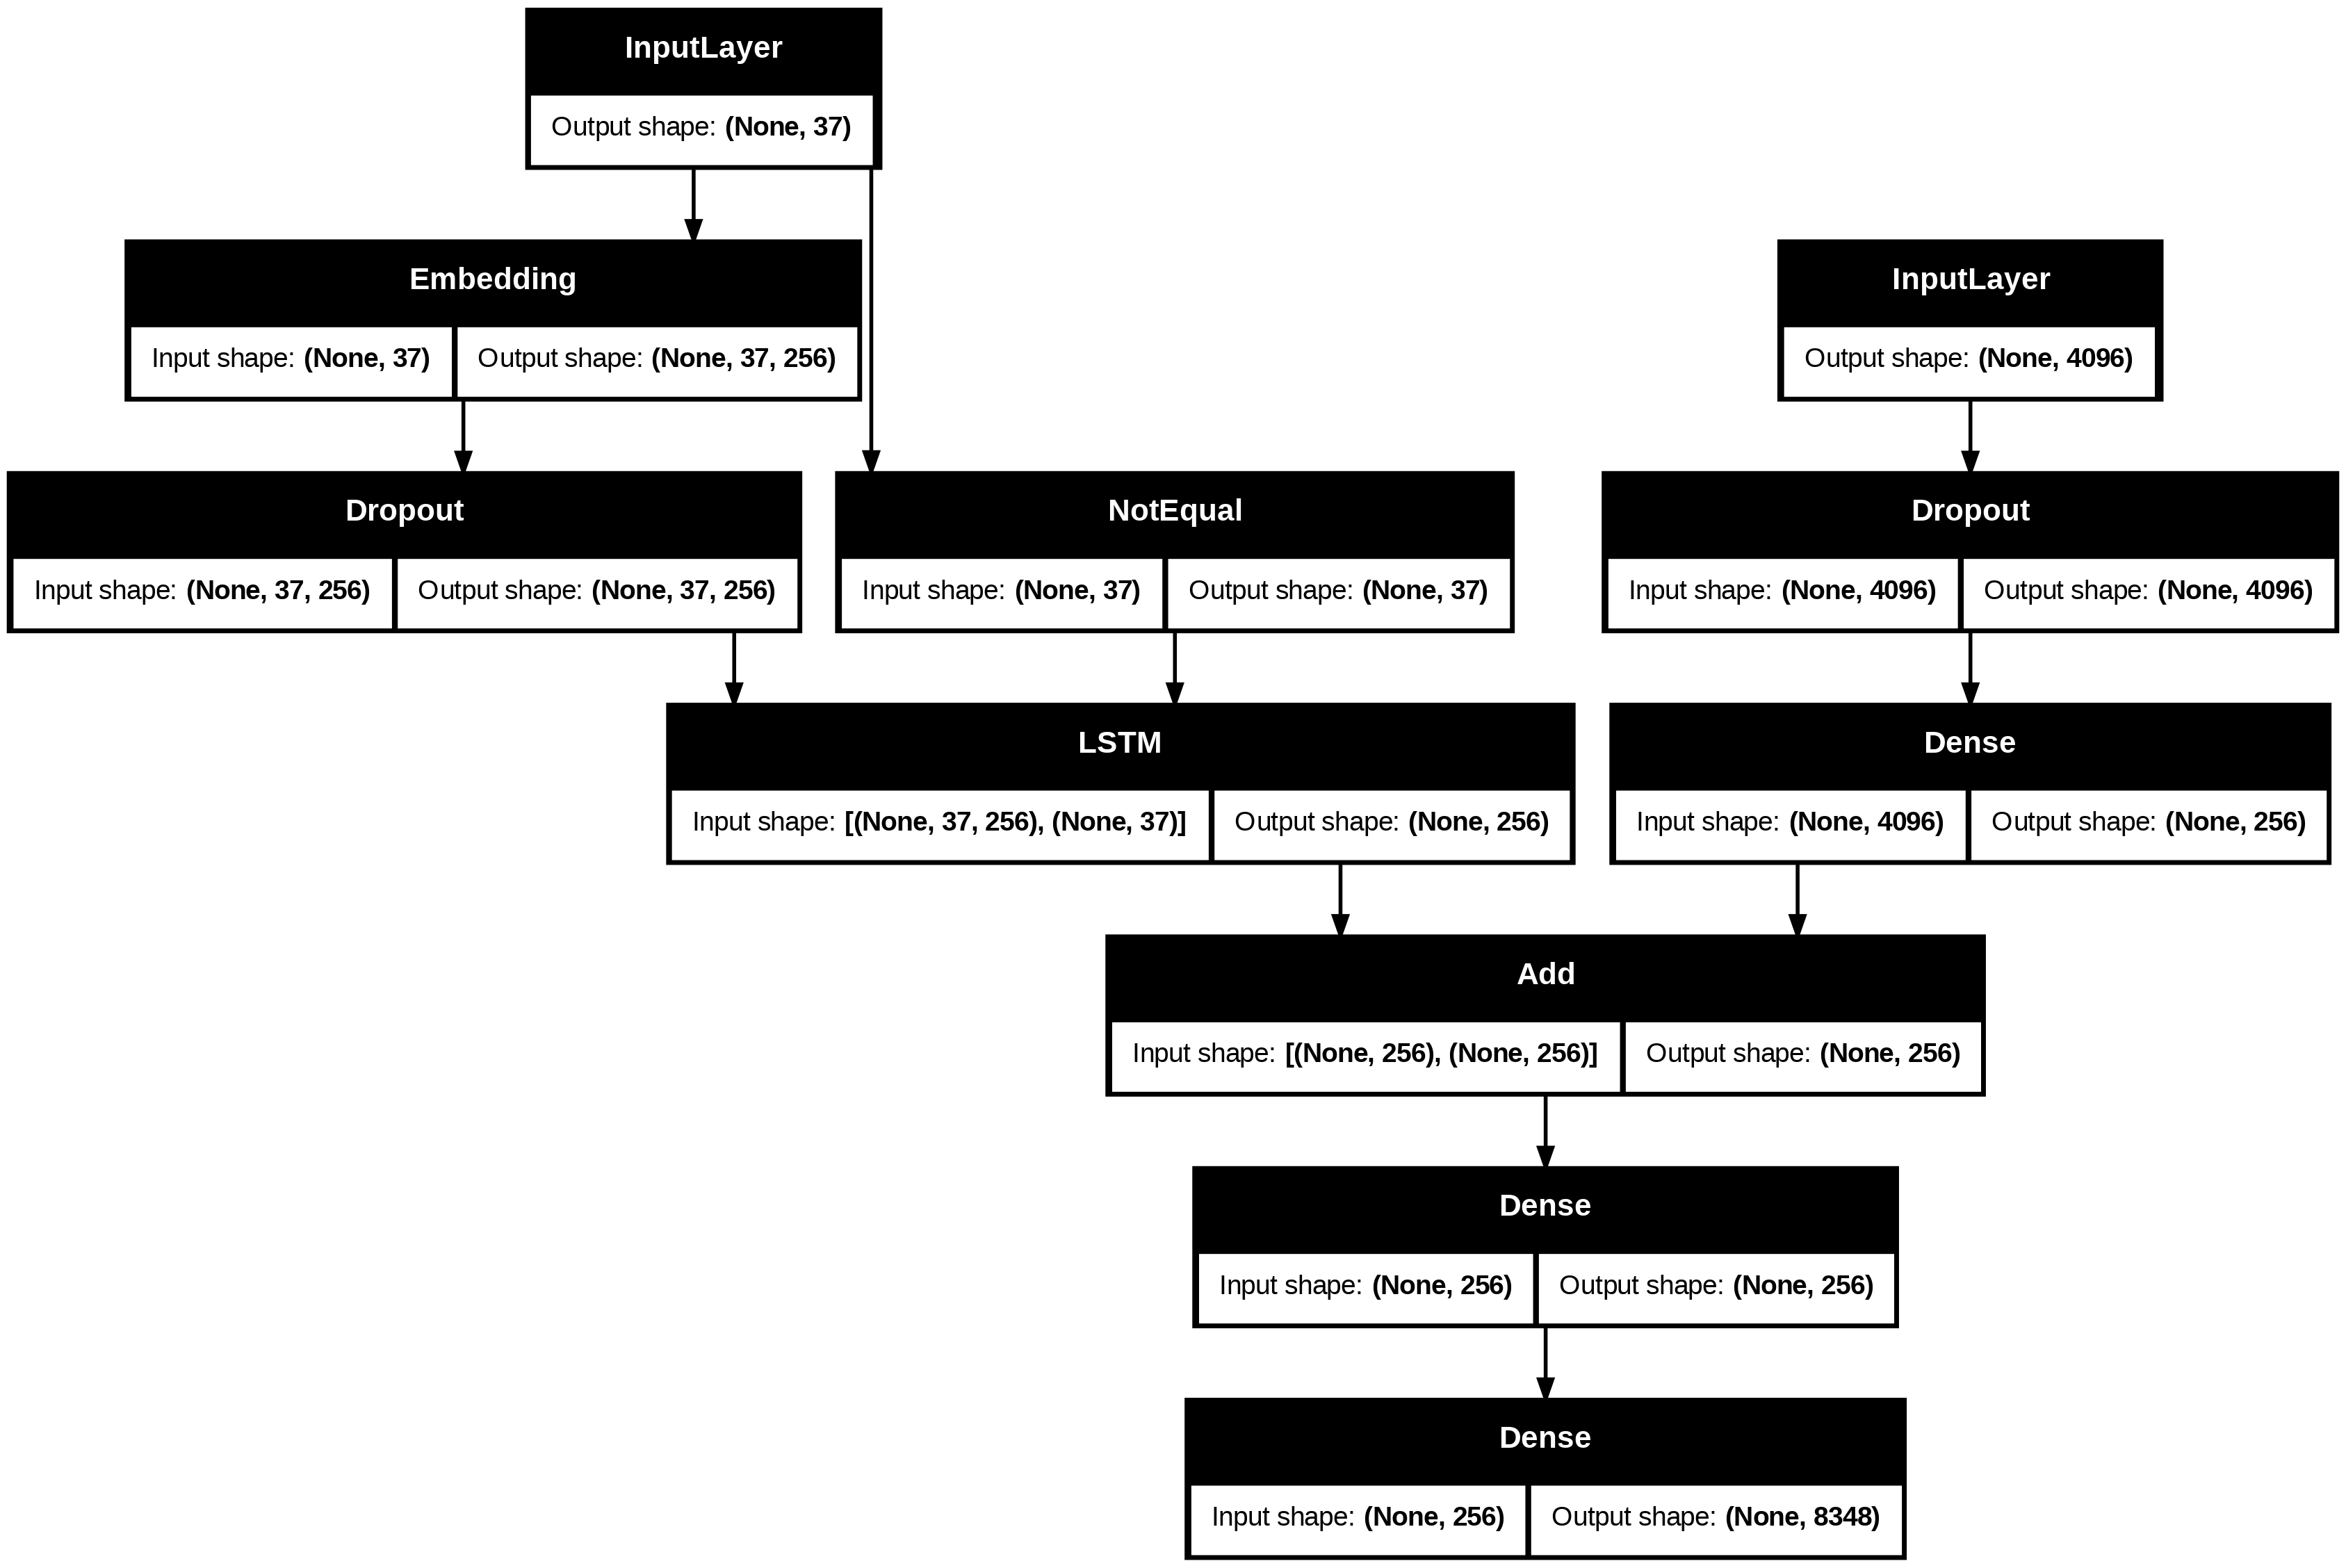

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# train the model
epochs = 15
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 238ms/step - loss: 5.5565
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - loss: 3.8172
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 240ms/step - loss: 3.3770
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 242ms/step - loss: 3.1113
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 242ms/step - loss: 2.9188
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 242ms/step - loss: 2.7773
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 239ms/step - loss: 2.6708
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 239ms/step - loss: 2.5780
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 242ms/step - loss: 2.4983
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 244ms/step - loss: 2.4357
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 244ms/step - loss: 2.3845
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 245ms/step - loss: 2.3350
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 249ms/step - loss: 2.2926
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 253ms/step - loss: 2.2429
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 253ms/step - loss: 2.2019


In [ ]:
MODEL_DIR = '/content/drive/MyDrive/AIML'
MODEL_PATH = MODEL_DIR + '/best_model.keras'


In [ ]:
# save the model (FINAL FIX)
model.save(MODEL_PATH)

print("Model saved successfully at:", MODEL_PATH)


Model saved successfully at: /content/drive/MyDrive/AIML/best_model.keras


Generate Captions for the Image

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.026316
BLEU-2: 0.000000
BLEU-1: 0.0263

Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    # get image ID (without extension)
    image_id = image_name.split('.')[0]

    # correct image path
    img_path = os.path.join(BASE_DIR, 'Images', image_name)

    # load and show image
    image = Image.open(img_path)

    # actual captions
    captions = mapping[image_id]
    print('--------------------Actual--------------------')
    for caption in captions:
        print(caption)

    # predicted caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('------------------Predicted------------------')
    print(y_pred)

    plt.imshow(image)
    plt.axis('off')


--------------------Actual--------------------
startseq are two men riding bicycles outside in the snow covered countryside endseq
startseq two men and their bikes are on the side of a snowy road endseq
startseq men on bicycles on the side of a snowpacked road in the country endseq
startseq men stop on a snow covered hill with their bicycles endseq
startseq men taking a break from riding their bikes on a snowy road endseq
------------------Predicted------------------
startseq man is hiking on a snow covered hill endseq


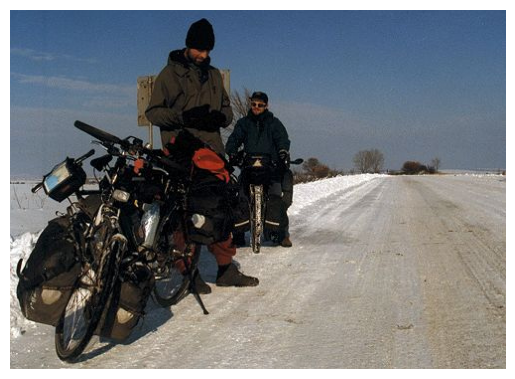

In [ ]:
generate_caption("95734035_84732a92c1.jpg")

--------------------Actual--------------------
startseq calico cat raising its paws towards a dog with an open mouth endseq
startseq cat swatting at a doberman dog endseq
startseq dog and cat are fighting on a chair endseq
startseq multicolor cat fighting with a black and brown dog in a red collar endseq
startseq yellow and black cat and the brown and black dog are fighting endseq
------------------Predicted------------------
startseq dog is jumping up on a red object endseq


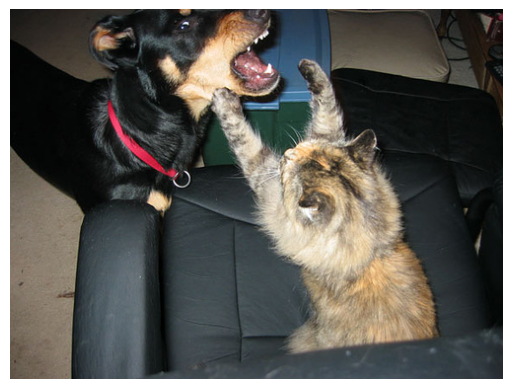

In [ ]:
generate_caption("97406261_5eea044056.jpg")